In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [2]:
df = pd.read_csv("insurance.csv")

In [3]:
from matplotlib import pyplot as plt
import seaborn as sns

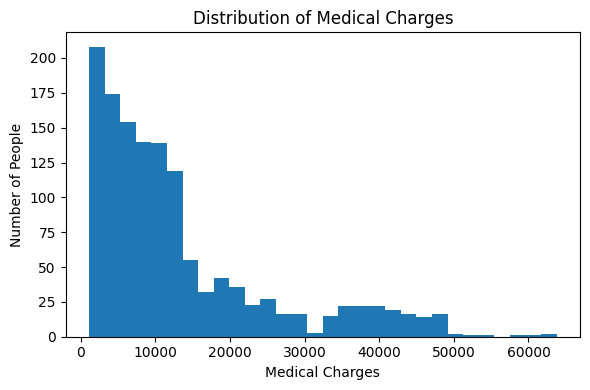

In [4]:
plt.figure(figsize=(6, 4))
plt.hist(df['charges'], bins=30)
plt.xlabel("Medical Charges")
plt.ylabel("Number of People")
plt.title("Distribution of Medical Charges")
plt.tight_layout()
plt.show()


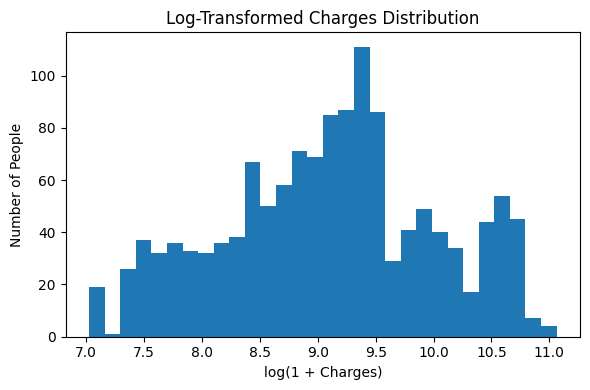

In [5]:
plt.figure(figsize=(6, 4))
plt.hist(np.log1p(df['charges']), bins=30)
plt.xlabel("log(1 + Charges)")
plt.ylabel("Number of People")
plt.title("Log-Transformed Charges Distribution")
plt.tight_layout()
plt.show()

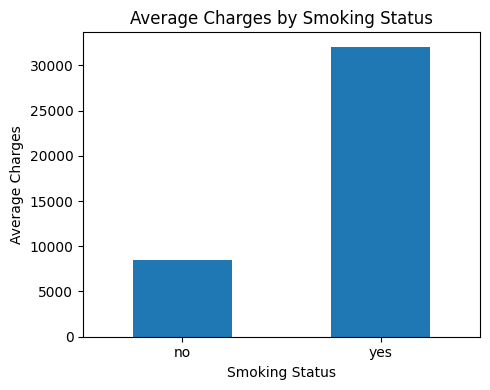

In [6]:
plt.figure(figsize=(5, 4))
df.groupby('smoker')['charges'].mean().plot(kind='bar')
plt.ylabel("Average Charges")
plt.xlabel("Smoking Status")
plt.title("Average Charges by Smoking Status")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

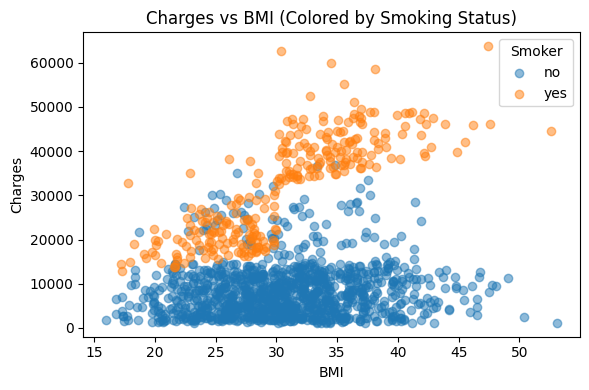

In [7]:
plt.figure(figsize=(6, 4))
for label, group in df.groupby('smoker'):
    plt.scatter(group['bmi'], group['charges'], alpha=0.5, label=label)

plt.xlabel("BMI")
plt.ylabel("Charges")
plt.title("Charges vs BMI (Colored by Smoking Status)")
plt.legend(title="Smoker")
plt.tight_layout()
plt.show()

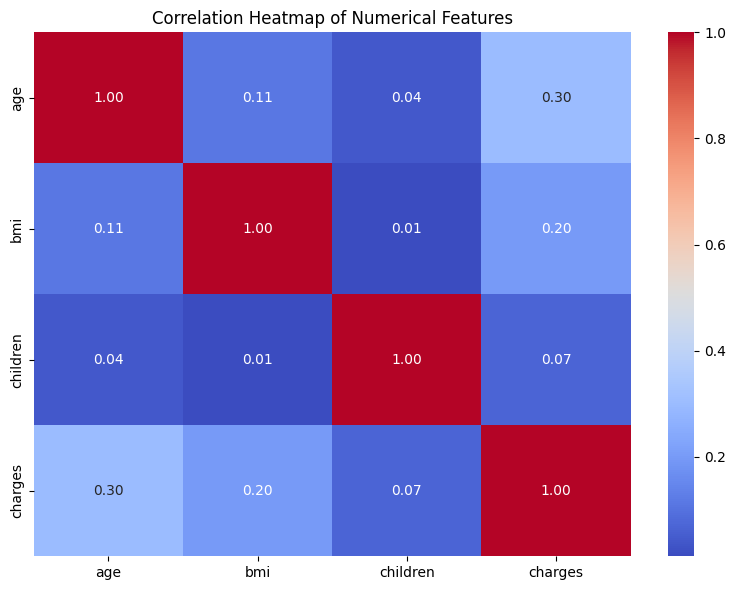

In [8]:
import seaborn as sns

num_cols = df.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = df[num_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Numerical Features")
plt.tight_layout()
plt.show()


In [9]:
X = df.drop(['charges'], axis=1)
y_reg = df['charges']

num = ['age', 'bmi', 'children']
cat = ['sex', 'smoker', 'region']

In [10]:
seg_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat)
    ],
    remainder='passthrough'
)

X_seg = seg_preprocessor.fit_transform(X)


In [11]:
seg_tree = DecisionTreeRegressor(
    max_depth=4,
    min_samples_leaf=20,
    random_state=42
)
seg_tree.fit(X_seg, y_reg)

DecisionTreeRegressor(max_depth=4, min_samples_leaf=20, random_state=42)

In [12]:
leaf_ids = seg_tree.apply(X_seg)
y_cls = leaf_ids
unique_leaves, counts = np.unique(leaf_ids, return_counts=True)
print("Number of cost segments (classes):", len(unique_leaves))
print("Some segments with counts:")
for leaf, c in list(zip(unique_leaves, counts))[:10]:
    print(f"  Leaf {leaf}: {c} samples")

Number of cost segments (classes): 16
Some segments with counts:
  Leaf 4: 41 samples
  Leaf 5: 32 samples
  Leaf 7: 30 samples
  Leaf 8: 27 samples
  Leaf 11: 45 samples
  Leaf 12: 33 samples
  Leaf 14: 28 samples
  Leaf 15: 38 samples
  Leaf 19: 207 samples
  Leaf 20: 46 samples


In [13]:
segment_summary = (
    pd.DataFrame({'leaf': leaf_ids, 'charges': y_reg})
    .groupby('leaf')['charges']
    .agg(['count', 'min', 'max', 'mean'])
    .sort_values('mean')
)
print("\nCost segment summary (per leaf):")
print(segment_summary)


Cost segment summary (per leaf):
      count          min          max          mean
leaf                                               
19      207   1121.87390  25081.76784   3269.547236
22      267   1711.02680  28476.73499   6056.882648
20       46   3704.35450  21984.47061   6466.664387
23       76   3167.45585  27375.90478   8240.314160
26       84   6250.43500  32108.66282   9378.790720
27      115   7789.63500  30284.64294  10787.893942
29      161   9140.95100  35160.13457  12937.945051
30      108  11743.29900  36910.60803  15230.663972
4        41  12829.45510  35147.52848  17373.664785
5        32  15820.69900  32734.18630  19883.854469
7        30  18767.73770  35069.37452  23178.806347
8        27  21348.70600  38245.59327  27186.342128
11       45  32548.34050  43943.87610  36483.046860
12       33  35585.57600  58571.07448  40905.990562
14       28  38998.54600  62592.87309  43289.468311
15       38  41999.52000  63770.42801  47369.068023


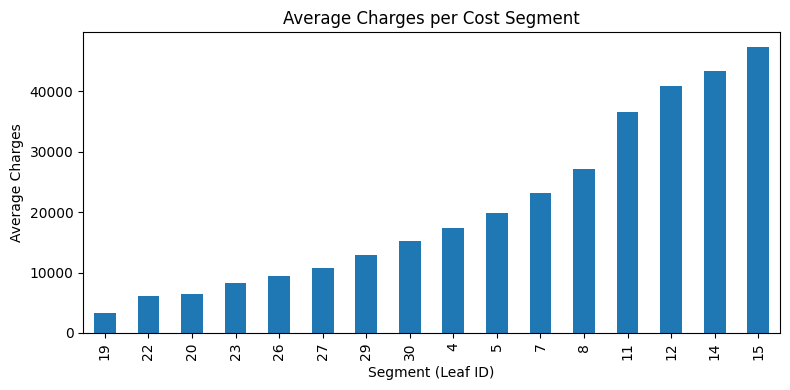

In [14]:
plt.figure(figsize=(8, 4))
segment_summary['mean'].plot(kind='bar')
plt.ylabel("Average Charges")
plt.xlabel("Segment (Leaf ID)")
plt.title("Average Charges per Cost Segment")
plt.tight_layout()
plt.show()


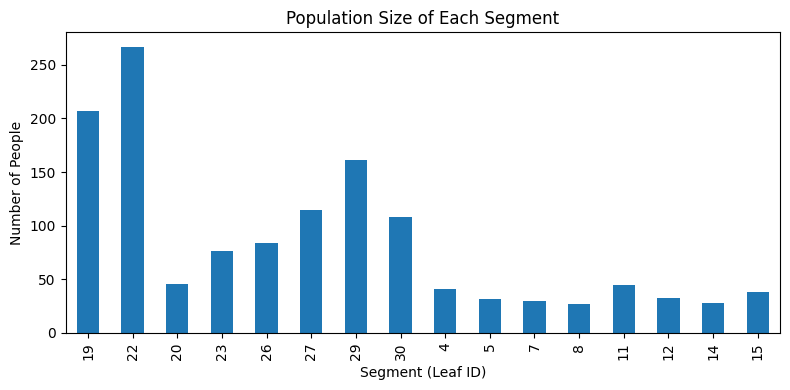

In [15]:
plt.figure(figsize=(8, 4))
segment_summary['count'].plot(kind='bar')
plt.ylabel("Number of People")
plt.xlabel("Segment (Leaf ID)")
plt.title("Population Size of Each Segment")
plt.tight_layout()
plt.show()

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_cls,
    test_size=0.2,
    random_state=42,
    stratify=y_cls
)

In [17]:
cls_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat)
    ],
    remainder='passthrough'
)

In [18]:
clf = Pipeline(steps=[
    ('preprocessor', cls_preprocessor),
    ('model', RandomForestClassifier(
        n_estimators=600,
        min_samples_split=4,
        min_samples_leaf=3,
        random_state=42
    ))
])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

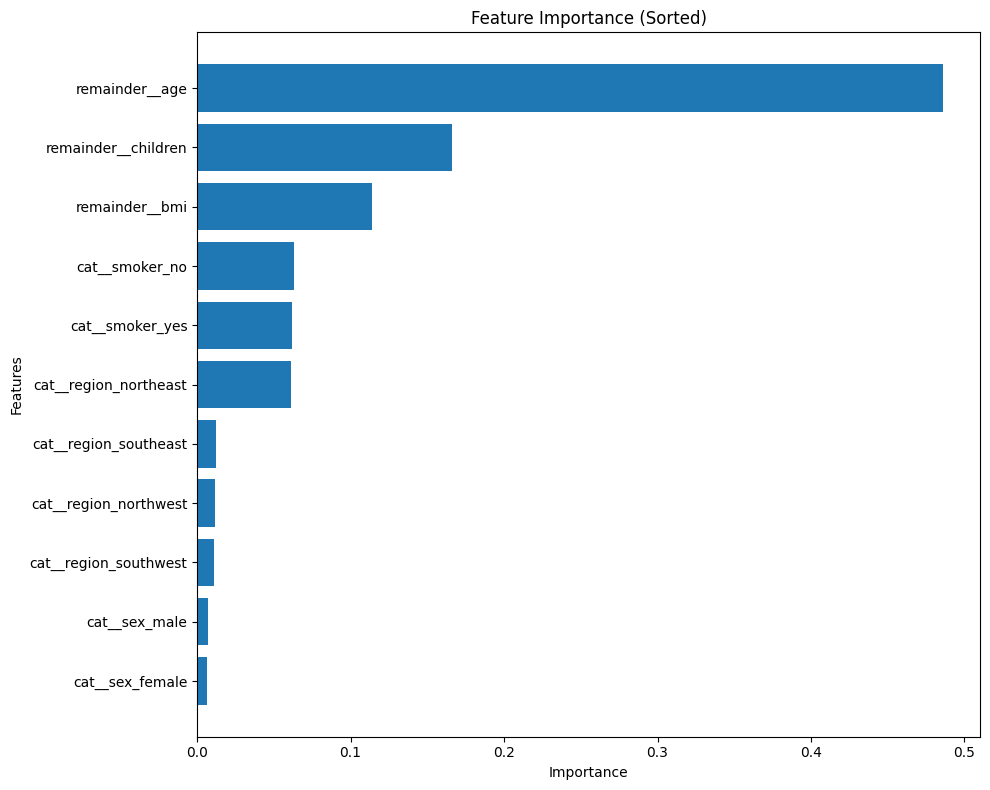

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

importances = clf.named_steps['model'].feature_importances_
feature_names = cls_preprocessor.get_feature_names_out()

fi_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(fi_df['Feature'], fi_df['Importance'])
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance (Sorted)")
plt.tight_layout()
plt.show()

<Figure size 600x600 with 0 Axes>

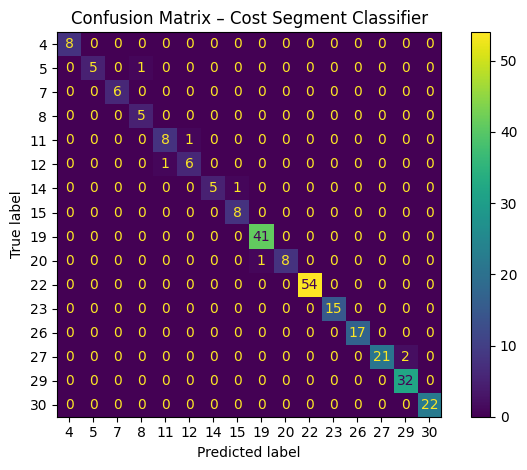

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay

plt.figure(figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix – Cost Segment Classifier")
plt.tight_layout()
plt.show()

In [21]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report
)
accuracy = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average='macro')
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
macro_precision = precision_score(y_test, y_pred, average='macro')
macro_recall = recall_score(y_test, y_pred, average='macro')

print(f"Accuracy:             {accuracy:.4f}")
print(f"Macro F1-score:       {macro_f1:.4f}")
print(f"Weighted F1-score:    {weighted_f1:.4f}")
print(f"Average Precision:    {macro_precision:.4f}")
print(f"Average Recall:       {macro_recall:.4f}")

print(classification_report(y_test, y_pred))



Accuracy:             0.9739
Macro F1-score:       0.9542
Weighted F1-score:    0.9737
Average Precision:    0.9616
Average Recall:       0.9509
              precision    recall  f1-score   support

           4       1.00      1.00      1.00         8
           5       1.00      0.83      0.91         6
           7       1.00      1.00      1.00         6
           8       0.83      1.00      0.91         5
          11       0.89      0.89      0.89         9
          12       0.86      0.86      0.86         7
          14       1.00      0.83      0.91         6
          15       0.89      1.00      0.94         8
          19       0.98      1.00      0.99        41
          20       1.00      0.89      0.94         9
          22       1.00      1.00      1.00        54
          23       1.00      1.00      1.00        15
          26       1.00      1.00      1.00        17
          27       1.00      0.91      0.95        23
          29       0.94      1.00      0.97 

In [22]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Regression Performance Metrics:")
print(f"R² Score:       {r2:.4f}")
print(f"MAE:            {mae:.4f}")
print(f"MSE:            {mse:.4f}")
print(f"RMSE:           {rmse:.4f}")

Regression Performance Metrics:
R² Score:       0.9984
MAE:            0.0410
MSE:            0.0784
RMSE:           0.2799


In [23]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import joblib

# Load classifier and segment summary (ensure you upload both)
clf = joblib.load("cost_classifier.pkl")         # your RandomForest + preprocessor pipeline
segment_summary = pd.read_pickle("segment_summary.pkl")  # saved summary table

st.set_page_config(page_title="Insurance Cost Segment Predictor", layout="centered")
st.title("Insurance Cost Segment Predictor")
st.write("Predict the cost segment based on user medical + demographic info.")

st.markdown("---")

# ----------- USER INPUT FORM -------------
with st.form("input_form"):
    st.subheader("Enter User Details")

    age = st.number_input("Age", min_value=1, max_value=100, value=25)
    bmi = st.number_input("BMI", min_value=10.0, max_value=60.0, value=22.5)
    children = st.number_input("Number of Children", min_value=0, max_value=10, value=0)

    sex = st.selectbox("Sex", ["male", "female"])
    smoker = st.selectbox("Smoker?", ["yes", "no"])
    region = st.selectbox("Region", ["southwest", "southeast", "northwest", "northeast"])

    submitted = st.form_submit_button("Predict")

if submitted:
    # Prepare input
    user_data = {
        "age": age,
        "sex": sex,
        "bmi": bmi,
        "children": children,
        "smoker": smoker,
        "region": region
    }

    input_df = pd.DataFrame([user_data])

    # Prediction
    predicted_segment = clf.predict(input_df)[0]
    seg_info = segment_summary.loc[predicted_segment]

    st.markdown("---")
    st.subheader("Prediction Result")

    st.success(f"### Predicted Segment: `{predicted_segment}`")

    st.write("#### Segment Statistics:")
    st.write(f"- **Customers in this segment:** {int(seg_info['count'])}")
    st.write(f"- **Min Cost:** ${seg_info['min']:.2f}")
    st.write(f"- **Max Cost:** ${seg_info['max']:.2f}")
    st.write(f"- **Average Cost:** ${seg_info['mean']:.2f}")

    st.markdown("---")
    st.write("Prediction complete!")


Writing app.py


In [24]:
import joblib

joblib.dump(clf, "cost_classifier.pkl")
segment_summary.to_pickle("segment_summary.pkl")


In [25]:
!pip install streamlit pyngrok


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 93.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 114.7 MB/s eta 0:00:00


In [26]:
from pyngrok import ngrok
ngrok.set_auth_token("36D4dAqYqztVnVAZFYQ5irMQSVK_2PCPB5izZS8jKxDjMSMa4")


In [27]:
!streamlit run app.py &>/content/logs.txt &
public_url = ngrok.connect(8501)
public_url


<NgrokTunnel: "https://unaching-enactable-flossie.ngrok-free.dev" -> "http://localhost:8501">